Set Shots - Expected Behind Model - Model Evaluation - GBM

In [1]:
import sys
sys.path.append("/Users/ciaran/Documents/Projects/AFL/git-repositories/expected-score-model/")

In [2]:
import pandas as pd
import numpy as np
import joblib
import warnings
warnings.filterwarnings('ignore')

from expected_score_model.config import set_shots_file_path
# from total_points_model.domain.preprocessing.data_preprocessor import DataPreprocessor
# from total_points_model.domain.contracts.mappings import Mappings
from expected_score_model.domain.contracts.modelling_data_contract import ModellingDataContract
from expected_score_model.domain.modelling.supermodel import SuperXGBClassifier
from expected_score_model.domain.modelling.model_evaluation import XGBClassifierEvaluator

pd.options.display.max_rows = 200
pd.options.display.max_columns = 999

%load_ext autoreload
%autoreload 2

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


New Model

In [3]:
new_version = 2
model_name = "expected_behind_set"
model_file_path = "/Users/ciaran/Documents/Projects/AFL/git-repositories/expected-score-model/model_outputs/models"
preproc_file_path = "/Users/ciaran/Documents/Projects/AFL/git-repositories/expected-score-model/model_outputs/preprocessors"

Comparison Model

In [4]:
old_version = new_version - 1
compare_train_predictions_file_path = "/Users/ciaran/Documents/Projects/AFL/git-repositories/expected-score-model/model_outputs/predictions/train_predictions_"+model_name+"_v"+str(old_version)+".csv"
compare_test_predictions_file_path = "/Users/ciaran/Documents/Projects/AFL/git-repositories/expected-score-model/model_outputs/predictions/test_predictions_"+model_name+"_v"+str(old_version)+".csv"

Response

In [5]:
RESPONSE = ModellingDataContract.RESPONSE_BEHIND

Load Data

In [6]:
df_modelling = pd.read_csv(set_shots_file_path)
df_modelling.tail()

,Chain_Number,Initial_State,Final_State,Order,Quarter,Quarter_Duration_Chain_Start,Quarter_Duration,Team_Chain,Team,Player,AFL_API_Player_ID,Description,x,y,Disposal,Shot_At_Goal,Behind_Detail,Venue_Width,Venue_Length,Home_Team,Away_Team,Home_Team_Direction_Q1,Match_ID,Round_ID,Year,Goal,Behind,Score,Home_Score,Away_Score,Home_Current_Score,Away_Current_Score,Current_Margin,Event_Type0,Event_Type1,Event_Type2,Event_Type3,x0,x1,x2,x3,y0,y1,y2,y3,Quarter_Duration0,Quarter_Duration1,Quarter_Duration2,Quarter_Duration3,Chain_Duration,Time_Since_Last_Action,Distance_Since_Last_Action,Distance_to_Right_Goal_x,Distance_to_Middle_y,Distance_to_Middle_Goal,Angle_to_Middle_Goal,Angle_to_Middle_Goal_degrees,Visible_Goal_Angle,Visible_Goal_Angle_degrees,Visible_Behind_Angle,Visible_Behind_Angle_degrees,Squared_Distance_to_Middle_Goal,Log_Distance_to_Middle_Goal,Set_Shot,random100,ModellingFilter
11052,208,possGain,behind,1663.0,4,634,683.0,Geelong,Geelong,Tom Hawkins,Tom_Hawkins,Kick,41.0,25.0,ineffective,True,NaN,141,160,Geelong,Sydney,left,2022F4_Geelong_Sydney,2022F4,2022,0,1,1,1,0,106.0,33.0,73.0,Kick,Mark On Lead,Kick Inside 50 Result,Kick Into F50,41.0,48.0,48.0,26.0,25.0,21.0,21.0,14.0,683.0,644.0,642.0,641.0,49.0,39.0,8.062258,39.0,25.0,46.324939,0.570040,32.660913,0.116867,6.695990,0.364585,20.889203,1521.0,3.663562,True,10,True
11053,212,kickIn,goal,1730.0,4,787,885.0,Geelong,Geelong,Patrick Dangerfield,Patrick_Dangerfield,Kick,51.0,43.0,ineffective,True,NaN,141,160,Geelong,Sydney,left,2022F4_Geelong_Sydney,2022F4,2022,0,1,1,1,0,108.0,34.0,74.0,Kick,Contested Mark,Contest Target,Kick Inside 50 Result,51.0,53.0,53.0,53.0,43.0,38.0,38.0,38.0,885.0,852.0,851.0,850.0,98.0,33.0,5.385165,29.0,43.0,51.865210,0.977446,56.003541,0.069260,3.968302,0.214332,12.280314,841.0,3.367296,True,66,True
11054,213,centreBounce,goal,1754.0,4,956,979.0,Sydney,Sydney,Paddy McCartin,Paddy_McCartin,Kick,66.0,0.0,effective,True,NaN,141,160,Geelong,Sydney,left,2022F4_Geelong_Sydney,2022F4,2022,1,0,6,0,6,115.0,34.0,81.0,Kick,Free For,Kick Inside 50 Result,Kick Into F50,66.0,74.0,74.0,27.0,0.0,0.0,0.0,17.0,979.0,977.0,968.0,967.0,23.0,2.0,8.000000,14.0,0.0,14.000000,0.000000,0.000000,0.482343,27.636207,2.588598,148.315731,196.0,2.639057,True,12,True
11055,219,centreBounce,goal,1846.0,4,1252,1266.0,Sydney,Sydney,Chad Warner,Chad_Warner,Kick,26.0,3.0,effective,True,NaN,141,160,Geelong,Sydney,left,2022F4_Geelong_Sydney,2022F4,2022,1,0,6,0,6,121.0,40.0,81.0,Kick,Uncontested Mark,Ground Kick,Handball,26.0,18.0,-5.0,-2.0,3.0,2.0,-4.0,3.0,1266.0,1265.0,1264.0,1260.0,14.0,1.0,8.062258,54.0,3.0,54.083269,0.055499,3.179830,0.118569,6.793500,0.365993,20.969862,2916.0,3.988984,True,18,True
11056,228,centreBounce,goal,1912.0,4,1519,1560.0,Geelong,Geelong,Jeremy Cameron,Jeremy_Cameron,Kick,41.0,21.0,effective,True,NaN,141,160,Geelong,Sydney,left,2022F4_Geelong_Sydney,2022F4,2022,1,0,6,6,0,127.0,46.0,81.0,Kick,Mark On Lead,Kick Inside 50 Result,Kick Into F50,41.0,49.0,49.0,25.0,21.0,17.0,17.0,33.0,1560.0,1535.0,1532.0,1531.0,41.0,25.0,8.944272,39.0,21.0,44.294469,0.493941,28.300756,0.127885,7.327246,0.400462,22.944787,1521.0,3.663562,True,93,False


In [7]:
training_data = df_modelling[df_modelling[ModellingDataContract.TRAIN_TEST_SPLIT_COL]]
test_data = df_modelling[~df_modelling[ModellingDataContract.TRAIN_TEST_SPLIT_COL]]

In [8]:
X_train, y_train = training_data.drop(columns=[RESPONSE]), training_data[RESPONSE]
X_test, y_test = test_data.drop(columns=[RESPONSE]), test_data[RESPONSE]

In [9]:
X_test.head()

,Chain_Number,Initial_State,Final_State,Order,Quarter,Quarter_Duration_Chain_Start,Quarter_Duration,Team_Chain,Team,Player,AFL_API_Player_ID,Description,x,y,Disposal,Shot_At_Goal,Behind_Detail,Venue_Width,Venue_Length,Home_Team,Away_Team,Home_Team_Direction_Q1,Match_ID,Round_ID,Year,Goal,Score,Home_Score,Away_Score,Home_Current_Score,Away_Current_Score,Current_Margin,Event_Type0,Event_Type1,Event_Type2,Event_Type3,x0,x1,x2,x3,y0,y1,y2,y3,Quarter_Duration0,Quarter_Duration1,Quarter_Duration2,Quarter_Duration3,Chain_Duration,Time_Since_Last_Action,Distance_Since_Last_Action,Distance_to_Right_Goal_x,Distance_to_Middle_y,Distance_to_Middle_Goal,Angle_to_Middle_Goal,Angle_to_Middle_Goal_degrees,Visible_Goal_Angle,Visible_Goal_Angle_degrees,Visible_Behind_Angle,Visible_Behind_Angle_degrees,Squared_Distance_to_Middle_Goal,Log_Distance_to_Middle_Goal,Set_Shot,random100,ModellingFilter
6,72,possGain,goal,696.0,2,462,506.0,Sydney,Sydney,Isaac Heeney,Isaac_Heeney,Kick,47.0,35.0,effective,True,NaN,138,156,Brisbane Lions,Sydney,right,202101_BrisbaneLions_Sydney,202101,2021,1,6,0,6,20.0,28.0,-8.0,Kick,Mark On Lead,Kick Inside 50 Result,Kick Into F50,47.0,53.0,53.0,42.0,35.0,27.0,27.0,41.0,506.0,468.0,466.0,465.0,44.0,38.0,10.000000,31.0,35.0,46.754679,0.845930,48.468229,0.091187,5.224603,0.284262,16.287036,961.0,3.433987,True,90,False
10,108,possGain,goal,982.0,2,1782,1859.0,Sydney,Sydney,Sam Reid,Sam_Reid,Kick,40.0,36.0,effective,True,NaN,138,156,Brisbane Lions,Sydney,right,202101_BrisbaneLions_Sydney,202101,2021,1,6,0,6,50.0,46.0,4.0,Kick,Uncontested Mark,Kick,Uncontested Mark,40.0,44.0,43.0,50.0,36.0,32.0,48.0,40.0,1859.0,1835.0,1833.0,1814.0,77.0,24.0,5.656854,38.0,36.0,52.345009,0.758378,43.451842,0.089092,5.104600,0.275545,15.787586,1444.0,3.637586,True,95,False
27,15,ballUp,behind,140.0,1,453,464.0,Collingwood,Collingwood,Brody Mihocek,Brody_Mihocek,Kick,31.0,-23.0,ineffective,True,NaN,141,160,Collingwood,Western Bulldogs,right,202101_Collingwood_WesternBulldogs,202101,2021,0,1,1,0,0.0,18.0,-18.0,Kick,Mark On Lead,Kick,Bounce,31.0,34.0,-7.0,-8.0,-23.0,-32.0,-5.0,-5.0,464.0,461.0,460.0,460.0,11.0,3.0,9.486833,49.0,23.0,54.129474,0.438859,25.144786,0.107406,6.153916,0.331520,18.994682,2401.0,3.891820,True,96,False
39,156,throwIn,miss,1357.0,3,766,816.0,Western Bulldogs,Western Bulldogs,Josh Bruce,Josh_Bruce,Kick,42.0,38.0,clanger,True,NaN,141,160,Collingwood,Western Bulldogs,right,202101_Collingwood_WesternBulldogs,202101,2021,0,0,0,0,36.0,48.0,-12.0,Kick,Free For,Kick Inside 50 Result,Kick Into F50,42.0,46.0,46.0,-1.0,38.0,34.0,34.0,61.0,816.0,784.0,772.0,771.0,50.0,32.0,5.656854,38.0,38.0,53.740115,0.785398,45.000000,0.084510,4.842076,0.260959,14.951857,1444.0,3.637586,True,91,False
41,195,possGain,miss,1617.0,3,1666,1697.0,Western Bulldogs,Western Bulldogs,Aaron Naughton,Aaron_Naughton,Kick,46.0,-44.0,ineffective,True,NaN,141,160,Collingwood,Western Bulldogs,right,202101_Collingwood_WesternBulldogs,202101,2021,0,1,0,1,36.0,62.0,-26.0,Kick,Mark On Lead,Kick,Handball Received,46.0,46.0,14.0,10.0,-44.0,-42.0,-32.0,-28.0,1697.0,1670.0,1668.0,1667.0,31.0,27.0,2.000000,34.0,44.0,55.605755,0.912908,52.305760,0.070609,4.045598,0.217612,12.468227,1156.0,3.526361,True,81,False


Preprocess Data

In [10]:
# preprocessor = DataPreprocessor()
# preprocessor.fit(X_train)

# X_train_preproc = preprocessor.transform(X_train)
# X_test_preproc = preprocessor.transform(X_test)

In [11]:
X_train_preproc = X_train[ModellingDataContract.modelling_feature_list]
X_test_preproc = X_test[ModellingDataContract.modelling_feature_list]

In [12]:
X_train_preproc.shape, X_test_preproc.shape

((8729, 2), (2328, 2))

In [13]:
X_train_preproc.head()

,Distance_to_Middle_Goal,Angle_to_Middle_Goal
0,52.009614,0.908067
1,43.600459,0.931882
2,36.674242,0.451453
3,33.015148,0.957589
4,46.572524,0.260602


In [14]:
X_test_preproc.head()

,Distance_to_Middle_Goal,Angle_to_Middle_Goal
6,46.754679,0.845930
10,52.345009,0.758378
27,54.129474,0.438859
39,53.740115,0.785398
41,55.605755,0.912908


Load Model

In [15]:
xgb_model = joblib.load(model_file_path + "/" + model_name + "_v" + str(new_version) + ".joblib")

Get Predictions

In [16]:
train_preds = xgb_model.predict(X_train_preproc)
test_preds = xgb_model.predict(X_test_preproc)

In [17]:
train_probas = xgb_model.predict_proba(X_train_preproc)[:, 1]
test_probas = xgb_model.predict_proba(X_test_preproc)[:, 1]

Compare Model

In [18]:
compare_train_data = pd.read_csv(compare_train_predictions_file_path)
compare_test_data = pd.read_csv(compare_test_predictions_file_path)

In [19]:
compare_train_data = compare_train_data.rename(columns = {'xgb_preds':'old_preds',
                                                          'xgb_probas':'old_probas'})
compare_test_data = compare_test_data.rename(columns = {'xgb_preds':'old_preds',
                                                        'xgb_probas':'old_probas'})

In [20]:
training_data = pd.merge(training_data, compare_train_data[["Match_ID", "Chain_Number", "Order", 'old_preds', 'old_probas']], how = "left", on = ["Match_ID", "Chain_Number", "Order"])
test_data = pd.merge(test_data, compare_test_data[["Match_ID", "Chain_Number", 'Order', 'old_preds', 'old_probas']], how = "left", on = ["Match_ID", "Chain_Number", "Order"])

Evaluate Model

In [21]:
training_data['xgb_preds'] = train_preds
training_data['xgb_probas'] = train_probas

train_xgb_evals = XGBClassifierEvaluator(model = xgb_model,
                                       data = training_data,
                                       actual_name = RESPONSE,
                                       expected_name = "xgb_probas",
                                       expected_label_name = "xgb_preds",
                                       compare_name='old_probas',
                                       compare_label_name="old_preds"
                                       )

In [22]:
test_data['xgb_preds'] = test_preds
test_data['xgb_probas'] = test_probas

test_xgb_evals = XGBClassifierEvaluator(model = xgb_model,
                                       data = test_data,
                                       actual_name = RESPONSE,
                                       expected_name = "xgb_probas",
                                       expected_label_name = "xgb_preds",
                                       compare_name='old_probas',
                                       compare_label_name="old_preds"
                                       )

Model Averages

In [23]:
train_xgb_evals.data[[RESPONSE, 'xgb_probas', 'old_probas']].describe()

,Behind,xgb_probas,old_probas
count,8729.000000,8729.000000,8729.000000
mean,0.421469,0.422879,0.423409
std,0.493823,0.189818,0.169695
min,0.000000,0.028660,0.054028
25%,0.000000,0.299684,0.291029
50%,0.000000,0.441225,0.441839
75%,1.000000,0.583775,0.552184
max,1.000000,0.882352,0.784373


In [24]:
test_xgb_evals.data[[RESPONSE, 'xgb_probas', 'old_probas']].describe()

,Behind,xgb_probas,old_probas
count,2328.000000,2328.000000,2328.000000
mean,0.434708,0.423896,0.425748
std,0.495825,0.191113,0.172490
min,0.000000,0.028660,0.054028
25%,0.000000,0.286265,0.284431
50%,0.000000,0.441225,0.441076
75%,1.000000,0.584395,0.563013
max,1.000000,0.835121,0.784373


Plots

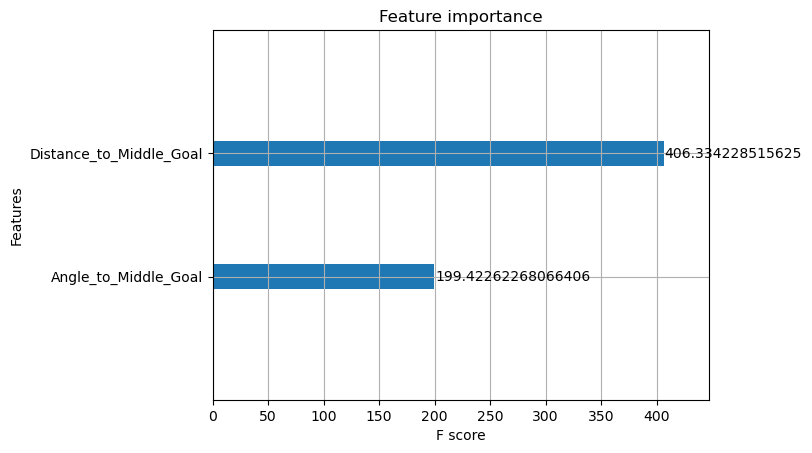

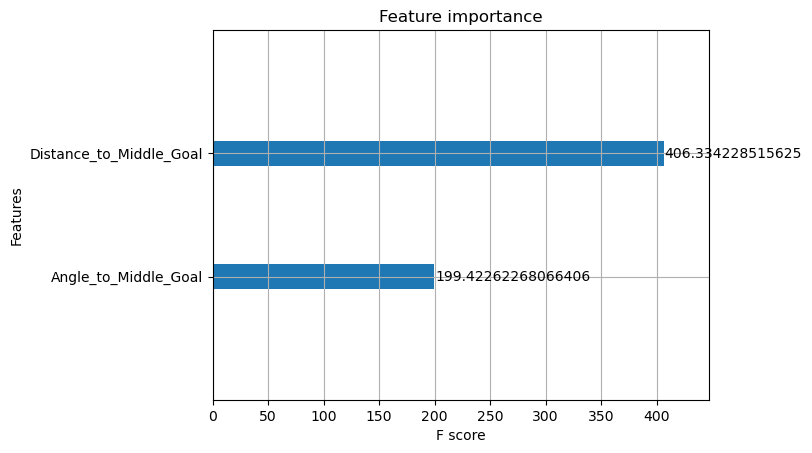

In [25]:
train_xgb_evals.plot_feature_importance(max_num_features=10, importance_type="total_gain")
test_xgb_evals.plot_feature_importance(max_num_features=10, importance_type="total_gain")

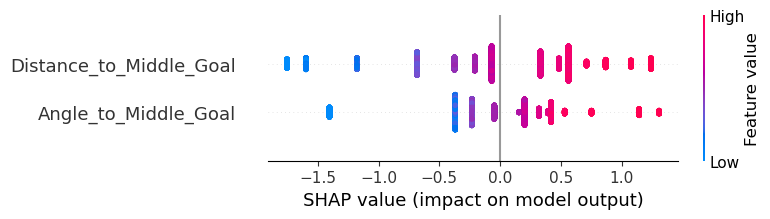

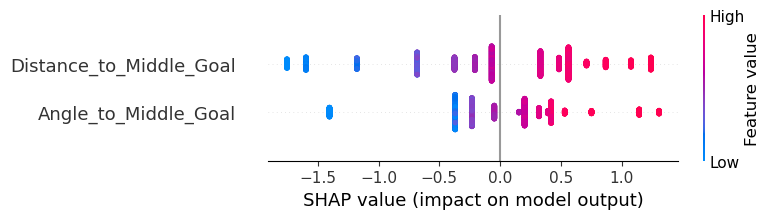

In [26]:
train_xgb_evals.plot_shap_summary_plot()
test_xgb_evals.plot_shap_summary_plot()

In [27]:
top_features = test_xgb_evals.get_ranked_feature_importance()
top_10_features = top_features[:10]
top_10_features

['Distance_to_Middle_Goal', 'Angle_to_Middle_Goal']

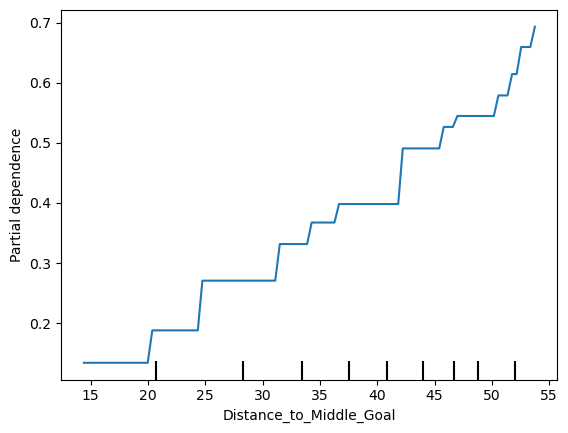

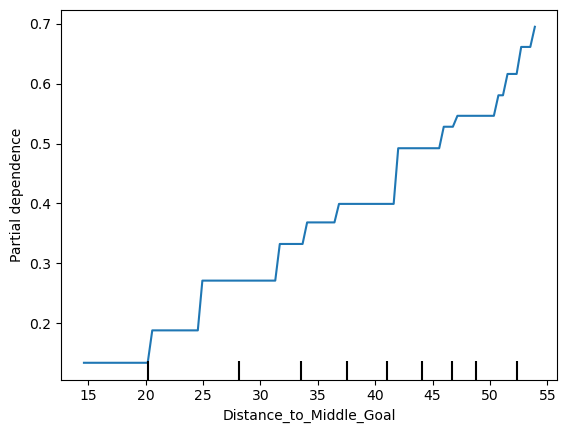

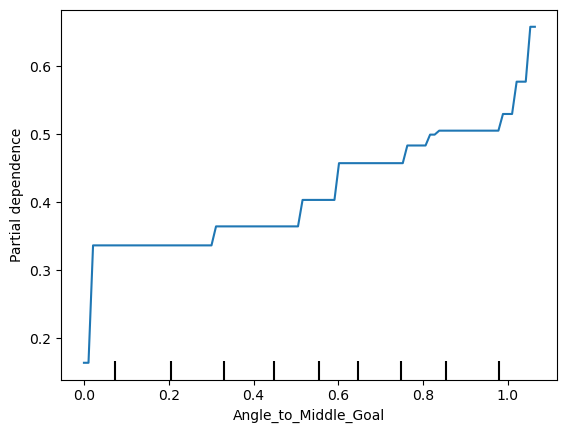

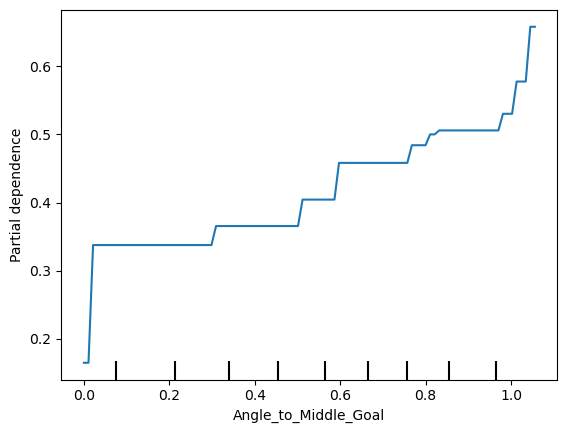

In [28]:
for col in top_10_features:
    train_xgb_evals.plot_pdp([col])
    test_xgb_evals.plot_pdp([col])

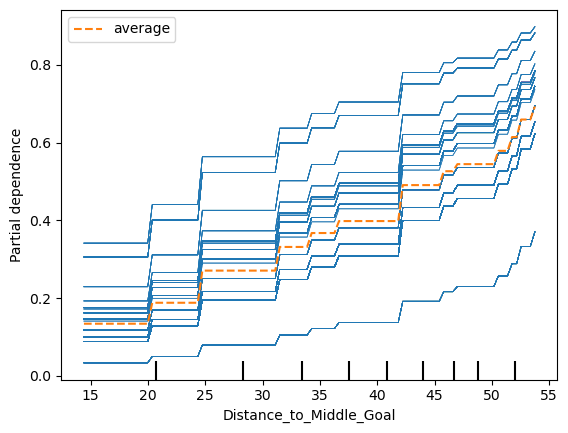

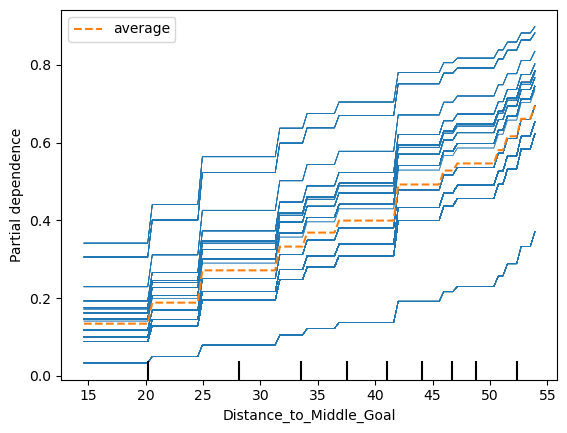

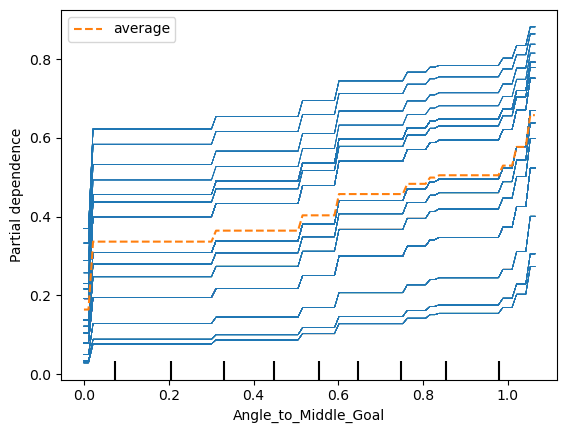

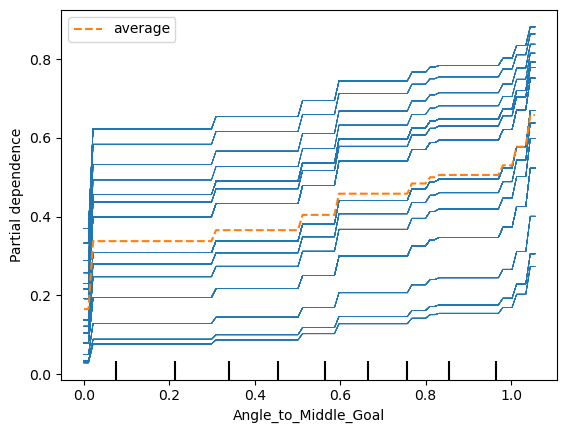

In [29]:
for col in top_10_features:
    train_xgb_evals.plot_ice([col])
    test_xgb_evals.plot_ice([col])

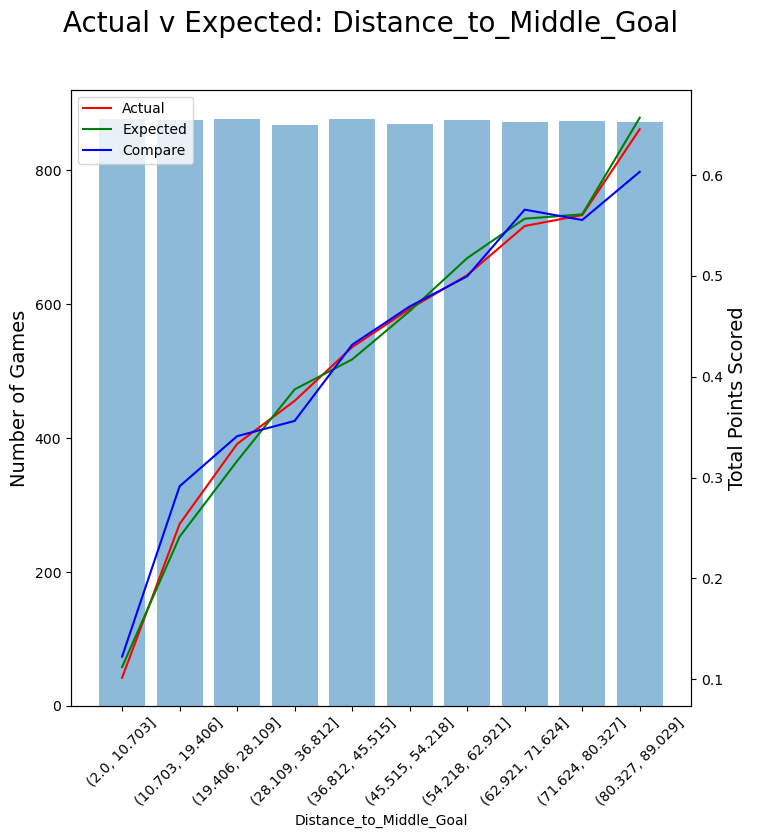

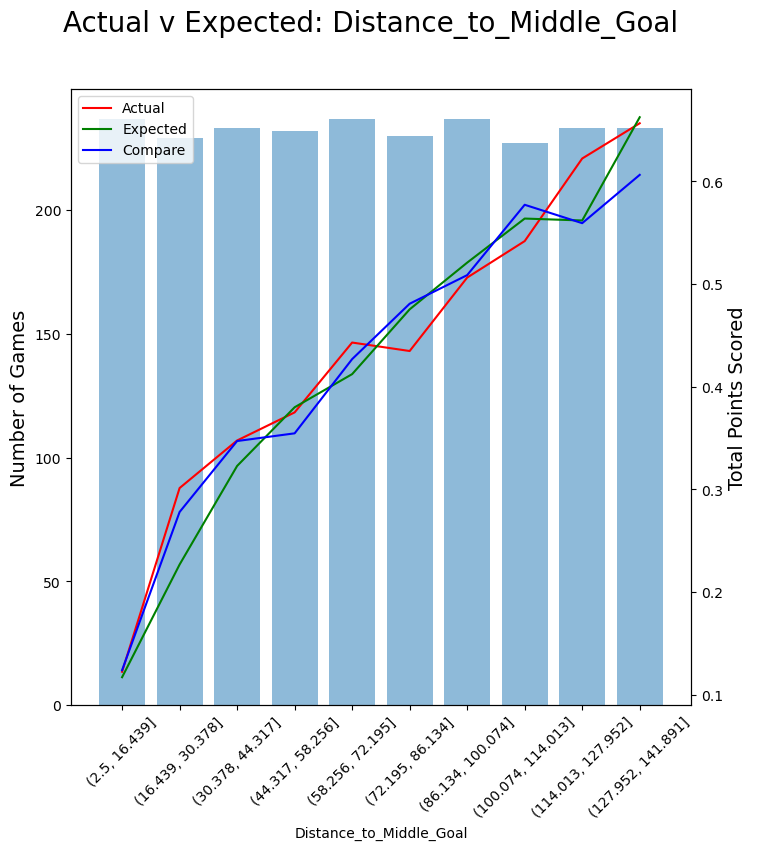

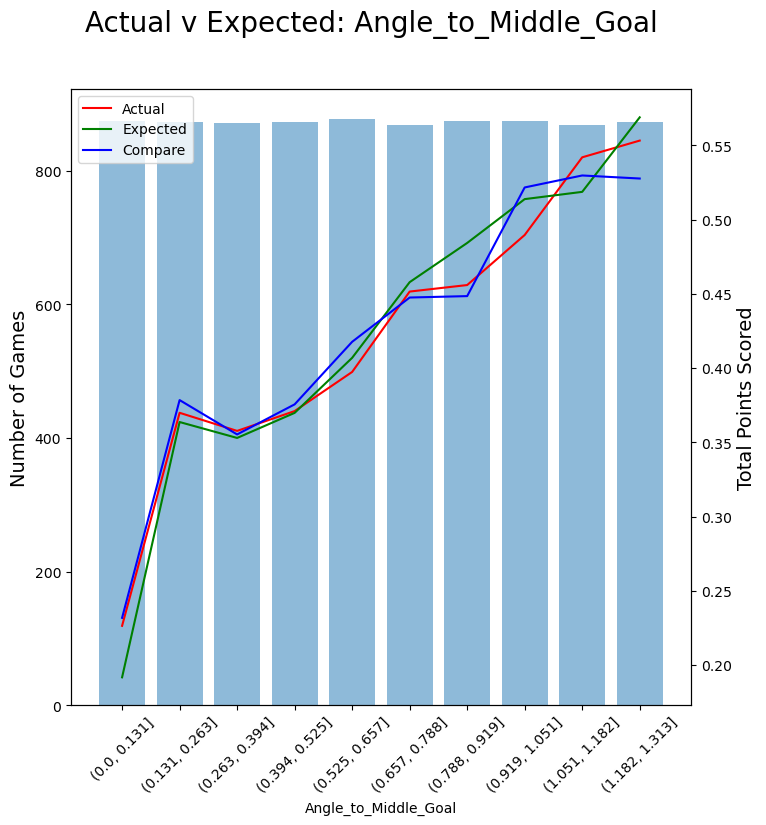

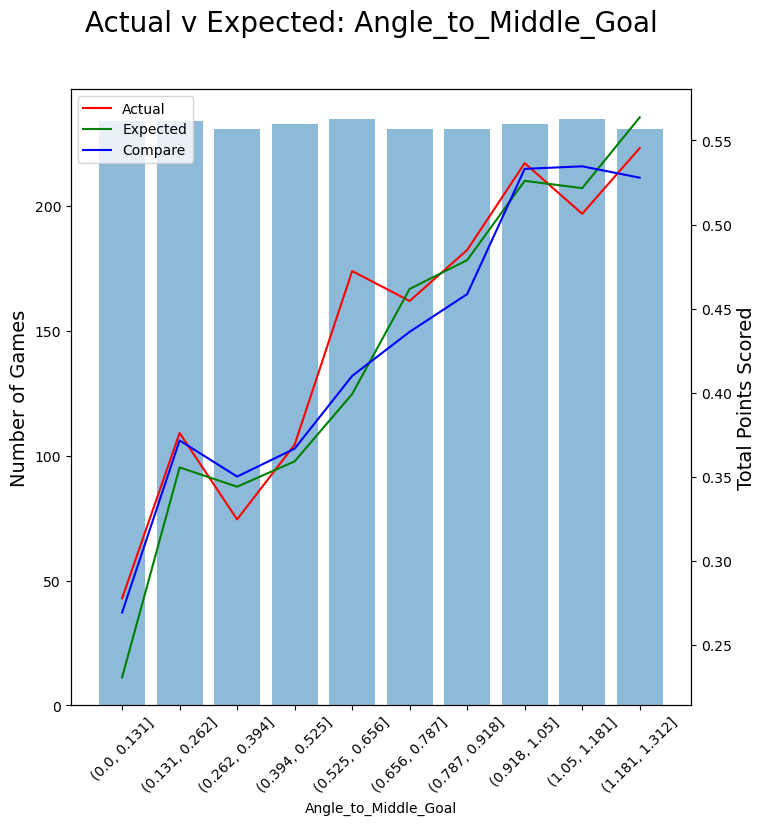

In [30]:
for col in top_10_features:
    train_xgb_evals.plot_feature_ave(col)
    test_xgb_evals.plot_feature_ave(col)

Model Metrics (for probabilities, mainly want calibration curve, logloss and brier score loss)

In [35]:
print("Training Set: ")
train_xgb_evals.get_log_loss()
print("Test Set: ")
test_xgb_evals.get_log_loss()

Training Set: 
Expected Log-Loss: 	0.6088
Compare Log-Loss: 	0.6063
Test Set: 
Expected Log-Loss: 	0.6230
Compare Log-Loss: 	0.6260


(0.6230044768929651, 0.6230044768929651)

In [36]:
print("Training Set: ")
train_xgb_evals.get_brier_score_loss()
print("Test Set: ")
test_xgb_evals.get_brier_score_loss()

Training Set: 
Expected Brier Score: 	0.2127
Compare Brier Score: 	0.2114
Test Set: 
Expected Brier Score: 	0.2190
Compare Brier Score: 	0.2202


(0.21903490592817446, 0.22019047835871322)

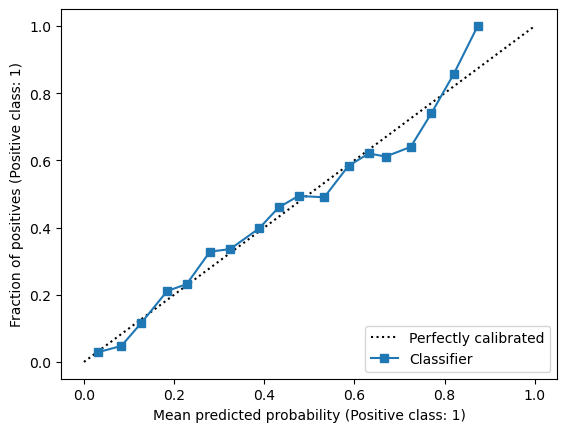

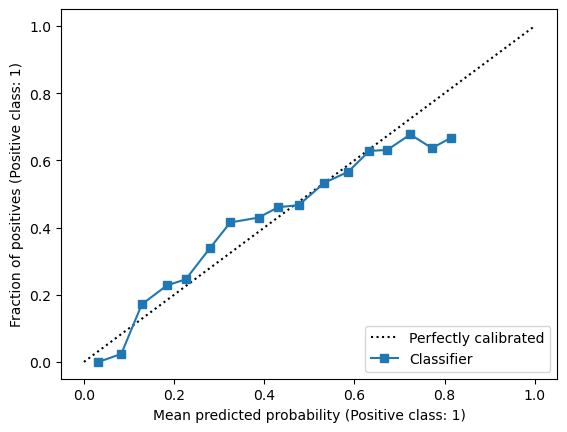

In [37]:
train_xgb_evals.display_calibration_curve(nbins=20)
test_xgb_evals.display_calibration_curve(nbins=20)

In [ ]:
train_xgb_evals.get_auc_score(), test_xgb_evals.get_auc_score()

In [ ]:
train_xgb_evals.get_confusion_matrix(), test_xgb_evals.get_confusion_matrix()

In [ ]:
train_xgb_evals.display_confusion_matrix()
test_xgb_evals.display_confusion_matrix()

In [ ]:
train_xgb_evals.plot_roc_curve()
test_xgb_evals.plot_roc_curve()

In [ ]:
train_xgb_evals.plot_prauc_curve()
test_xgb_evals.plot_prauc_curve()

In [ ]:
train_xgb_evals.get_accuracy(), test_xgb_evals.get_accuracy()

In [ ]:
train_xgb_evals.get_recall(), test_xgb_evals.get_recall()

In [ ]:
train_xgb_evals.get_precision(), test_xgb_evals.get_precision()

In [ ]:
train_xgb_evals.get_f1_score(), test_xgb_evals.get_f1_score()